In [1]:
import glob

import torch
import numpy as np
from scipy.io import loadmat

from timedenoiser.models.cnn import ShallowCNN
from timedenoiser.models.encdec import *
from timedenoiser.models.unet import UNET_1D
from timedenoiser.models.ekf import ekf
from timedenoiser.models.tv1d import tv
from timedenoiser.models.wt import wt

from motormetrics.ml import *
from motormetrics.ee import *

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# !cat ../../../datasets/Data_27012021_noisy/metadata.json

In [3]:
model_id = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_iq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_ud = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_uq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')

# model_id = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_iq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_ud = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_uq = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

# model_id = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_iq = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_ud = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_uq = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.01_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_id.eval()
model_iq.eval()
model_ud.eval()
model_uq.eval()

model_spd = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_current_d,current_q,voltage_d,voltage_q_outQuants_speed_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
model_trq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d,noisy_current_q,noisy_voltage_d,noisy_voltage_q_outQuants_torque_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_spd.eval()
model_trq.eval()

ShallowEncDec(
  (cnn1): Conv1d(4, 32, kernel_size=(10,), stride=(1,))
  (cnn2): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
  (cnn3): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (cnn4): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (dcnn4): ConvTranspose1d(256, 128, kernel_size=(3,), stride=(1,))
  (dcnn3): ConvTranspose1d(128, 64, kernel_size=(5,), stride=(1,))
  (dcnn2): ConvTranspose1d(64, 32, kernel_size=(7,), stride=(1,))
  (dcnn1): ConvTranspose1d(32, 1, kernel_size=(10,), stride=(1,))
  (act): ReLU()
)

In [25]:
class Exper():
        def __init__(self, kwargs):
            for k in kwargs:
                self.__dict__[k] = kwargs[k]
                
def compute_ml(data, speed_pred, torque_pred):
    ndata = {}
    for k in data.keys():
        if '__' not in k:
            ndata[k] = data[k][0]

    print ('Speed')
    print ('SMAPE :', smape(speed_pred, ndata['speed']))
    print ('R2 :', r2(speed_pred, ndata['speed']))
    print ('RMSE :', rmse(speed_pred, ndata['speed']))
    print ('MAE :', mae(speed_pred, ndata['speed']))

    print ('Torque')
    print ('SMAPE :', smape(torque_pred, ndata['torque']))
    print ('R2 :', r2(torque_pred, ndata['torque']))
    print ('RMSE :', rmse(torque_pred, ndata['torque']))
    print ('MAE :', mae(torque_pred, ndata['torque']))
    
def compute_ee(data, speed_pred, torque_pred):
    ndata = {}
    for k in data.keys():
        if '__' not in k:
            ndata[k] = data[k][0]

    ndata['speed'] = speed_pred
    ndata['torque'] = torque_pred
    model_exp = Exper(ndata)

    model_torque_metrics = compute_torque_metrics(model_exp)
    model_speed_metrics = compute_speed_metrics(model_exp)

    print (model_speed_metrics)
    print (model_torque_metrics)

bench1.mat


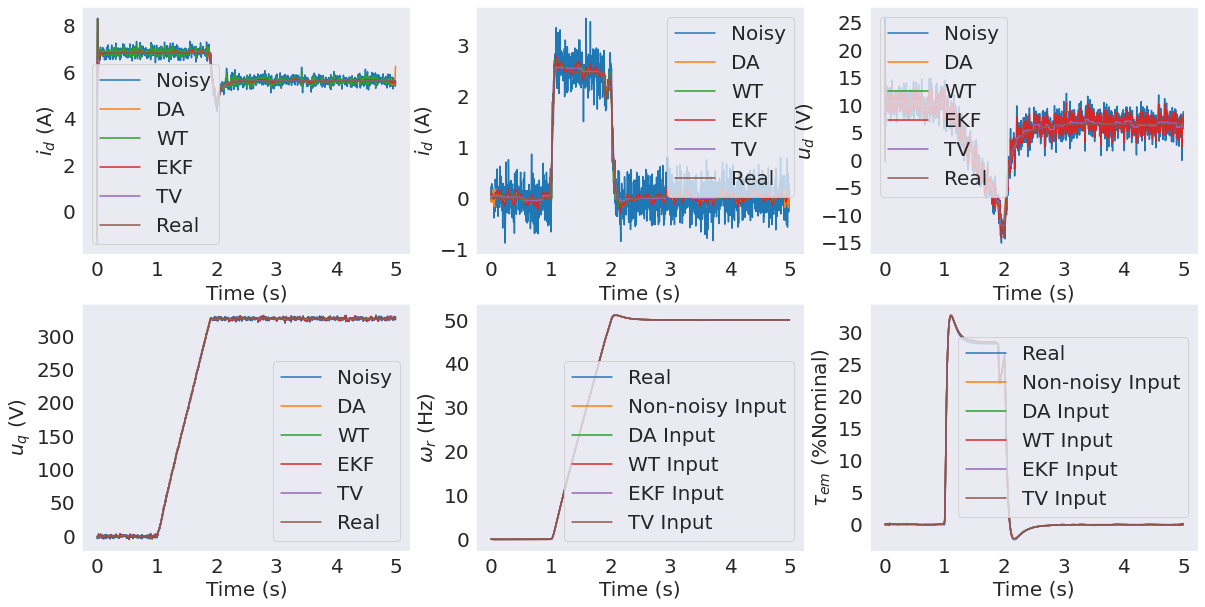

--------- Real -----------
{'perc2_times': [0.048], 'perc95_times': [0.96], 'following_errs': [-0.0198], 'following_times': [1.5], 'overshoot_errs': [2.1644], 'overshoot_times': [2.092], 'ramp_start_times': [1.0], 'sse_errs': [-0.0], 'sse_times': [4.8], 'max_trq_accs': [32.6913], 'max_trq_acc_times': [1.104]}
{'perc2_times': [], 'perc95_times': [], 'following_errs': [], 'following_times': [], 'overshoot_errs': [], 'overshoot_times': [], 'ramp_start_times': [], 'sse_errs': [], 'sse_times': [], 'speed_drops': [], 'speed_drops_times': []}
--------- Non-Noisy ----------
{'perc2_times': [0.048], 'perc95_times': [0.956], 'following_errs': [0.0081], 'following_times': [1.5], 'overshoot_errs': [2.3217], 'overshoot_times': [2.08], 'ramp_start_times': [1.0], 'sse_errs': [-0.0281], 'sse_times': [4.8], 'max_trq_accs': [32.8057], 'max_trq_acc_times': [1.108]}
{'perc2_times': [], 'perc95_times': [], 'following_errs': [], 'following_times': [], 'overshoot_errs': [], 'overshoot_times': [], 'ramp_start

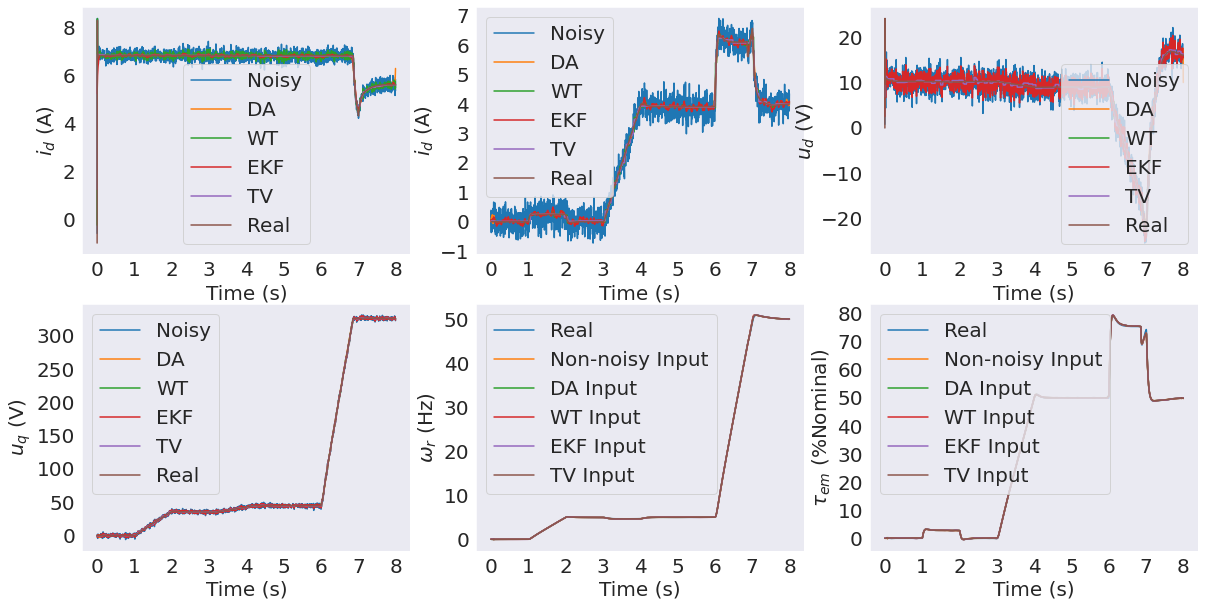

--------- Real -----------
{'perc2_times': [0.048, 0.048], 'perc95_times': [0.948, 0.968], 'following_errs': [-0.0019, -0.0242], 'following_times': [1.5, 6.5], 'overshoot_errs': [2.5516, 1.9721], 'overshoot_times': [2.052, 7.116], 'ramp_start_times': [1.0, 6.0], 'sse_errs': [0.0043, -0.0472], 'sse_times': [2.8, 7.8], 'max_trq_accs': [3.2677, 29.404], 'max_trq_acc_times': [1.104, 6.108]}
{'perc2_times': [0.048], 'perc95_times': [0.948], 'following_errs': [0.0298], 'following_times': [3.5], 'overshoot_errs': [2.3879], 'overshoot_times': [4.052], 'ramp_start_times': [3.0], 'sse_errs': [0.0455], 'sse_times': [4.8], 'speed_drops': [0.3376], 'speed_drops_times': [4.0]}
--------- Non-Noisy ----------
{'perc2_times': [0.048, 0.044], 'perc95_times': [0.952, 0.956], 'following_errs': [-0.0039, 0.0211], 'following_times': [1.5, 6.5], 'overshoot_errs': [1.9773, 1.9626], 'overshoot_times': [2.056, 7.088], 'ramp_start_times': [1.0, 6.0], 'sse_errs': [0.0271, -0.0496], 'sse_times': [2.8, 7.8], 'max_t

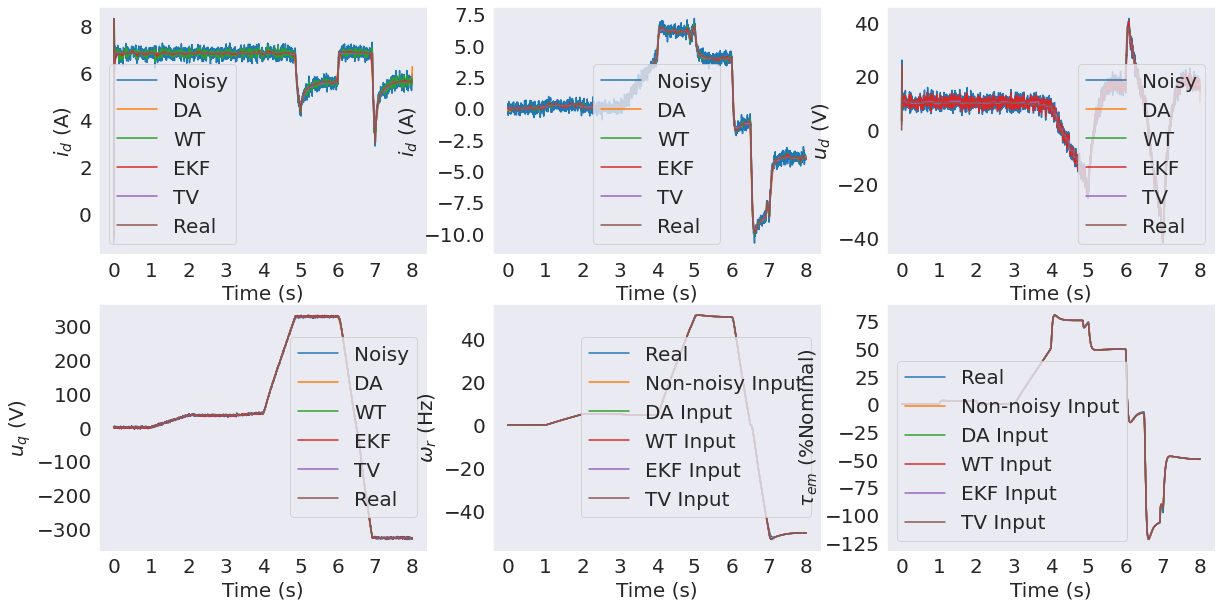

--------- Real -----------
{'perc2_times': [0.048, 0.052, 0.052], 'perc95_times': [0.948, 0.968, 0.956], 'following_errs': [-0.0019, -0.0234, 0.1015], 'following_times': [1.5, 4.5, 6.5], 'overshoot_errs': [2.5516, 1.972, 2.0036], 'overshoot_times': [2.052, 5.116, 7.112], 'ramp_start_times': [1.0, 4.0, 6.0], 'sse_errs': [0.0043, -0.0472, -0.0786], 'sse_times': [2.8, 5.8, 7.8], 'max_trq_accs': [3.2677, 30.3562, 172.3332], 'max_trq_acc_times': [1.104, 4.1, 6.616]}
{'perc2_times': [0.048], 'perc95_times': [2.0], 'following_errs': [0.0298], 'following_times': [3.5], 'overshoot_errs': [60.7125], 'overshoot_times': [4.1], 'ramp_start_times': [3.0], 'sse_errs': [-25.4448], 'sse_times': [4.8], 'speed_drops': [1.3739], 'speed_drops_times': [4.048]}
--------- Non-Noisy ----------
{'perc2_times': [0.048, 0.052, 0.052], 'perc95_times': [0.952, 0.956, 0.952], 'following_errs': [-0.0039, 0.0218, 0.2199], 'following_times': [1.5, 4.5, 6.5], 'overshoot_errs': [1.9773, 1.9626, 3.0367], 'overshoot_times'

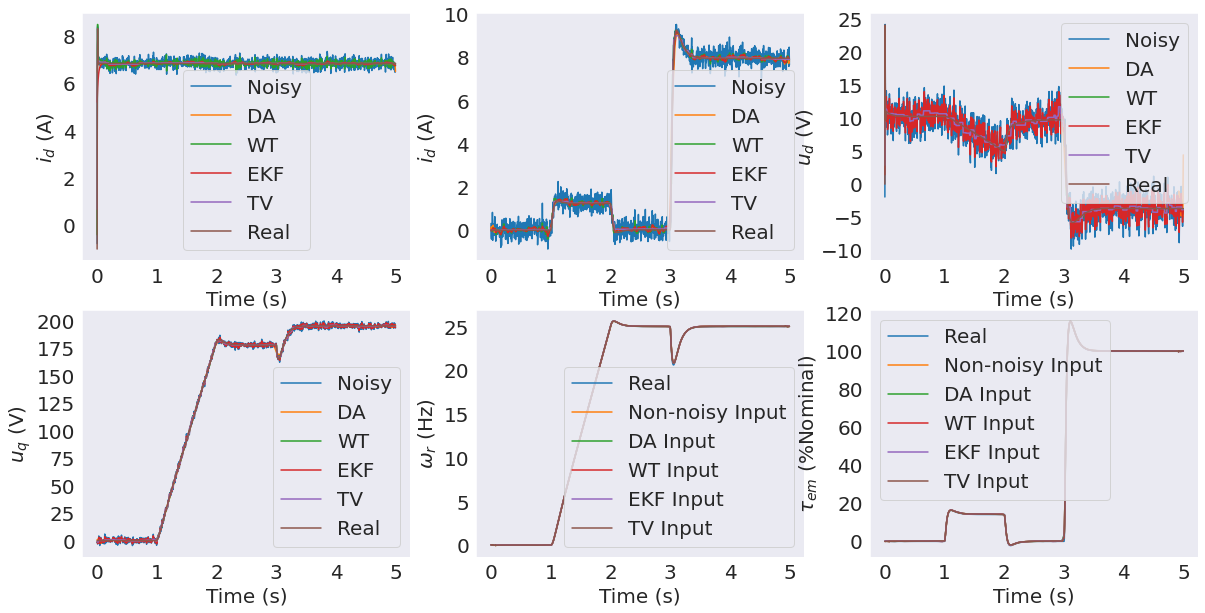

--------- Real -----------
{'perc2_times': [0.048], 'perc95_times': [0.948], 'following_errs': [-0.0095], 'following_times': [1.5], 'overshoot_errs': [2.5513], 'overshoot_times': [2.052], 'ramp_start_times': [1.0], 'sse_errs': [0.0012], 'sse_times': [2.8], 'max_trq_accs': [16.3422], 'max_trq_acc_times': [1.104]}
{'perc2_times': [0.008], 'perc95_times': [0.244], 'following_errs': [98.6784], 'following_times': [3.004], 'overshoot_errs': [15.9643], 'overshoot_times': [3.104], 'ramp_start_times': [3.0], 'sse_errs': [0.0082], 'sse_times': [4.8], 'speed_drops': [4.3945], 'speed_drops_times': [3.056]}
--------- Non-Noisy ----------
{'perc2_times': [0.048], 'perc95_times': [0.948], 'following_errs': [0.0032], 'following_times': [1.5], 'overshoot_errs': [2.474], 'overshoot_times': [2.06], 'ramp_start_times': [1.0], 'sse_errs': [-0.011], 'sse_times': [2.8], 'max_trq_accs': [16.4174], 'max_trq_acc_times': [1.108]}
{'perc2_times': [0.0], 'perc95_times': [0.244], 'following_errs': [95.7785], 'follo

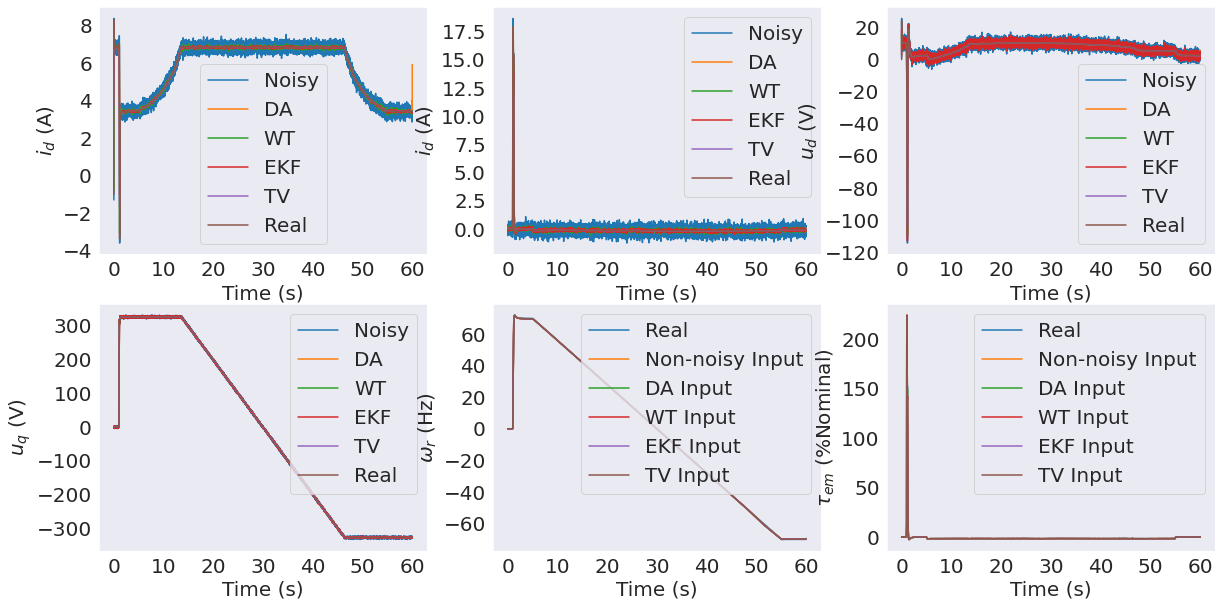

--------- Real -----------
{'perc2_times': [0.012, 1.008], 'perc95_times': [0.22, 47.5], 'following_errs': [69.7887, -0.0021], 'following_times': [1.004, 30.0], 'overshoot_errs': [3.1231, 0.088], 'overshoot_times': [1.376, 55.1], 'ramp_start_times': [1.0, 5.0], 'sse_errs': [-0.0037, -0.002], 'sse_times': [4.8, 59.8], 'max_trq_accs': [222.2401, 222.2401], 'max_trq_acc_times': [1.1, 1.1]}
{'perc2_times': [], 'perc95_times': [], 'following_errs': [], 'following_times': [], 'overshoot_errs': [], 'overshoot_times': [], 'ramp_start_times': [], 'sse_errs': [], 'sse_times': [], 'speed_drops': [], 'speed_drops_times': []}
--------- Non-Noisy ----------
{'perc2_times': [0.008, 0.968], 'perc95_times': [0.192, 47.344], 'following_errs': [69.1048, -0.0004], 'following_times': [1.004, 30.0], 'overshoot_errs': [2.6996, 0.005], 'overshoot_times': [1.372, 60.0], 'ramp_start_times': [1.0, 5.0], 'sse_errs': [0.2423, 0.1675], 'sse_times': [4.8, 59.8], 'max_trq_accs': [224.5082, 224.5082], 'max_trq_acc_tim

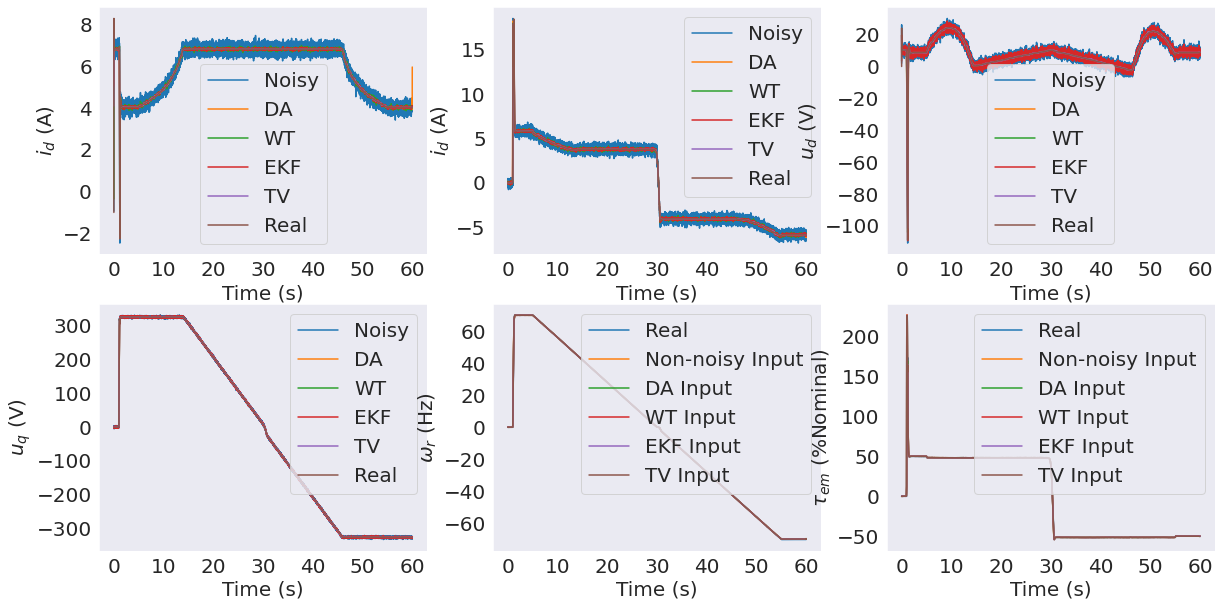

--------- Real -----------
{'perc2_times': [0.012, 1.036], 'perc95_times': [0.288, 47.52], 'following_errs': [69.8475, 0.257], 'following_times': [1.004, 30.0], 'overshoot_errs': [0.1051, 0.0349], 'overshoot_times': [1.476, 55.136], 'ramp_start_times': [1.0, 5.0], 'sse_errs': [-0.002, -0.002], 'sse_times': [4.8, 59.8], 'max_trq_accs': [174.1097, 174.1097], 'max_trq_acc_times': [1.132, 1.132]}
{'perc2_times': [], 'perc95_times': [], 'following_errs': [], 'following_times': [], 'overshoot_errs': [], 'overshoot_times': [], 'ramp_start_times': [], 'sse_errs': [], 'sse_times': [], 'speed_drops': [], 'speed_drops_times': []}
--------- Non-Noisy ----------
{'perc2_times': [0.012, 1.004], 'perc95_times': [0.256, 47.524], 'following_errs': [69.3193, 0.2574], 'following_times': [1.004, 30.0], 'overshoot_errs': [-0.1601, 0.005], 'overshoot_times': [4.92, 60.0], 'ramp_start_times': [1.0, 5.0], 'sse_errs': [0.1171, 0.2655], 'sse_times': [4.8, 59.8], 'max_trq_accs': [177.5143, 177.5143], 'max_trq_ac

In [26]:
mat_files = glob.glob('../../../datasets/Data_27012021_noisy/benchmark/bench*.mat')
mat_files.sort()

alpha = 0.1

spd_ekf_mae = []
spd_wt_mae = []
spd_tv_mae = []
spd_da_mae = []

trq_ekf_mae = []
trq_wt_mae = []
trq_tv_mae = []
trq_da_mae = []

spd_ekf_smape = []
spd_wt_smape = []
spd_tv_smape = []
spd_da_smape = []

trq_ekf_smape = []
trq_wt_smape = []
trq_tv_smape = []
trq_da_smape = []

for mat_file in mat_files:
    print (mat_file.split('/')[-1])
    
    data = loadmat(mat_file)

    st = 0
    w = -1

    x_id = np.stack([data['noisy_current_d'][0] / 30]) 
    x_iq = np.stack([data['noisy_current_q'][0] / 30])
    x_ud = np.stack([data['noisy_voltage_d'][0] / 300]) 
    x_uq = np.stack([data['noisy_voltage_q'][0] / 300])
    
    x = np.stack([data['current_d'][0] / 30, 
                      data['current_q'][0] / 30,
                      data['voltage_d'][0] / 300,
                      data['voltage_q'][0] / 300])


    inp_id = torch.tensor([x_id[:, st:st+w]]).cuda().float()
    out_id = model_id(inp_id)
    out_id_da = out_id.data.cpu().numpy()[0]
    out_id_wt = wt(data['noisy_current_d'][0], 0.17)
    out_id_ekf = ekf(data['noisy_current_d'][0], 0.17)
    out_id_tv = tv(data['noisy_current_d'][0], 0.17)

    inp_iq = torch.tensor([x_iq[:, st:st+w]]).cuda().float()
    out_iq = model_iq(inp_iq)
    out_iq_da = out_iq.data.cpu().numpy()[0]
    out_iq_wt = wt(data['noisy_current_q'][0], 0.29)
    out_iq_ekf = ekf(data['noisy_current_q'][0], 0.29)
    out_iq_tv = tv(data['noisy_current_q'][0], 0.29)

    inp_ud = torch.tensor([x_ud[:, st:st+w]]).cuda().float()
    out_ud = model_ud(inp_ud)
    out_ud_da = out_ud.data.cpu().numpy()[0]
    out_ud_wt = wt(data['noisy_voltage_d'][0], 1.85)
    out_ud_ekf = ekf(data['noisy_voltage_d'][0], 1.85)
    out_ud_tv = tv(data['noisy_voltage_d'][0], 1.85)

    inp_uq = torch.tensor([x_uq[:, st:st+w]]).cuda().float()
    out_uq = model_uq(inp_uq)
    out_uq_da = out_uq.data.cpu().numpy()[0]
    out_uq_wt = wt(data['noisy_voltage_q'][0], 1.78)
    out_uq_ekf = ekf(data['noisy_voltage_q'][0], 1.78)
    out_uq_tv = tv(data['noisy_voltage_q'][0], 1.78)
    
    inp = torch.tensor([x[:, st:st+w]]).cuda().float()
    out_spd = model_spd(inp)
    out_spd = out_spd.data.cpu().numpy()[0]
    
    out_trq = model_trq(inp)
    out_trq = out_trq.data.cpu().numpy()[0]

    inps_da = torch.from_numpy(np.stack([[out_id_da[0], 
                                           out_iq_da[0], 
                                           out_ud_da[0], 
                                           out_uq_da[0]]])).cuda()
    inps_wt = torch.from_numpy(np.stack([[out_id_wt / 30, 
                                           out_iq_wt / 30, 
                                           out_ud_wt / 300, 
                                           out_uq_wt / 300]])).cuda().float()
    inps_ekf = torch.from_numpy(np.stack([[out_id_ekf / 30, 
                                           out_iq_ekf / 30, 
                                           out_ud_ekf / 300, 
                                           out_uq_ekf / 300]])).cuda().float()
    inps_tv = torch.from_numpy(np.stack([[out_id_tv / 30, 
                                           out_iq_tv / 30, 
                                           out_ud_tv / 300, 
                                           out_uq_tv / 300]])).cuda().float()
    
    out_spd_da = model_spd(inps_da)
    out_spd_da = out_spd_da.data.cpu().numpy()[0]
    out_spd_wt = model_spd(inps_wt)
    out_spd_wt = out_spd_wt.data.cpu().numpy()[0]
    out_spd_ekf = model_spd(inps_ekf)
    out_spd_ekf = out_spd_ekf.data.cpu().numpy()[0]
    out_spd_tv = model_spd(inps_tv)
    out_spd_tv = out_spd_tv.data.cpu().numpy()[0]
    
    out_trq_da = model_trq(inps_da)
    out_trq_da = out_trq_da.data.cpu().numpy()[0]
    out_trq_wt = model_trq(inps_wt)
    out_trq_wt = out_trq_wt.data.cpu().numpy()[0]
    out_trq_ekf = model_trq(inps_ekf)
    out_trq_ekf = out_trq_ekf.data.cpu().numpy()[0]
    out_trq_tv = model_trq(inps_tv)
    out_trq_tv = out_trq_tv.data.cpu().numpy()[0]
    
    
    speed_pred = np.copy(data['speed'][0])
    speed_pred[:-1] = out_spd[0] * 80
    speed_pred = alpha * speed_pred + (1 - alpha) * data['speed'][0]

    torque_pred = np.copy(data['torque'][0])
    torque_pred[:-1] = out_trq[0] * 120
    torque_pred = alpha * torque_pred + (1 - alpha) * data['torque'][0]
    
    speed_pred_da = np.copy(data['speed'][0])
    speed_pred_da[:-1] = out_spd_da[0] * 80
    speed_pred_da = alpha * speed_pred_da + (1 - alpha) * data['speed'][0]

    torque_pred_da = np.copy(data['torque'][0])
    torque_pred_da[:-1] = out_trq_da[0] * 120
    torque_pred_da = alpha * torque_pred_da + (1 - alpha) * data['torque'][0]
    
    speed_pred_wt = out_spd_wt[0] * 80
    speed_pred_wt = alpha * speed_pred_wt + (1 - alpha) * data['speed'][0]

    torque_pred_wt = out_trq_wt[0] * 120
    torque_pred_wt = alpha * torque_pred_wt + (1 - alpha) * data['torque'][0]
    
    speed_pred_ekf = out_spd_ekf[0] * 80
    speed_pred_ekf = alpha * speed_pred_ekf + (1 - alpha) * data['speed'][0]

    torque_pred_ekf = out_trq_ekf[0] * 120
    torque_pred_ekf = alpha * torque_pred_ekf + (1 - alpha) * data['torque'][0]
    
    speed_pred_tv = out_spd_tv[0] * 80
    speed_pred_tv = alpha * speed_pred_tv + (1 - alpha) * data['speed'][0]

    torque_pred_tv = out_trq_tv[0] * 120
    torque_pred_tv = alpha * torque_pred_tv + (1 - alpha) * data['torque'][0]
    
    
    sns.set_style("dark")
    fig = plt.figure(figsize=(20,10))

    plt.subplot(2, 3, 1)
    plt.plot(data['time'][0, st:st+w], data['noisy_current_d'][0, st:st+w], label='Noisy')
    plt.plot(data['time'][0, st:st+w], out_id_da[0] * 30, label='DA')
    plt.plot(data['time'][0, st:st+w], out_id_wt[st:st+w], label='WT')
    plt.plot(data['time'][0, st:st+w], out_id_ekf[st:st+w], label='EKF')
    plt.plot(data['time'][0, st:st+w], out_id_tv[st:st+w], label='TV')
    plt.plot(data['time'][0, st:st+w], data['current_d'][0, st:st+w], label='Real')
    plt.ylabel(r'$i_d$ (A)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)

    plt.subplot(2, 3, 2)
    plt.plot(data['time'][0, st:st+w], data['noisy_current_q'][0, st:st+w], label='Noisy')
    plt.plot(data['time'][0, st:st+w], out_iq_da[0] * 30, label='DA')
    plt.plot(data['time'][0, st:st+w], out_iq_wt[st:st+w], label='WT')
    plt.plot(data['time'][0, st:st+w], out_iq_ekf[st:st+w], label='EKF')
    plt.plot(data['time'][0, st:st+w], out_iq_tv[st:st+w], label='TV')
    plt.plot(data['time'][0, st:st+w], data['current_q'][0, st:st+w], label='Real')
    plt.ylabel(r'$i_d$ (A)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)

    plt.subplot(2, 3, 3)
    plt.plot(data['time'][0, st:st+w], data['noisy_voltage_d'][0, st:st+w], label='Noisy')
    plt.plot(data['time'][0, st:st+w], out_ud_da[0] * 300, label='DA')
    plt.plot(data['time'][0, st:st+w], out_ud_wt[st:st+w], label='WT')
    plt.plot(data['time'][0, st:st+w], out_ud_ekf[st:st+w], label='EKF')
    plt.plot(data['time'][0, st:st+w], out_ud_tv[st:st+w], label='TV')
    plt.plot(data['time'][0, st:st+w], data['voltage_d'][0, st:st+w], label='Real')
    plt.ylabel(r'$u_d$ (V)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)

    plt.subplot(2, 3, 4)
    plt.plot(data['time'][0, st:st+w], data['noisy_voltage_q'][0, st:st+w], label='Noisy')
    plt.plot(data['time'][0, st:st+w], out_uq_da[0] * 300, label='DA')
    plt.plot(data['time'][0, st:st+w], out_uq_wt[st:st+w], label='WT')
    plt.plot(data['time'][0, st:st+w], out_uq_ekf[st:st+w], label='EKF')
    plt.plot(data['time'][0, st:st+w], out_uq_tv[st:st+w], label='TV')
    plt.plot(data['time'][0, st:st+w], data['voltage_q'][0, st:st+w], label='Real')
    plt.ylabel(r'$u_q$ (V)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    
    plt.subplot(2, 3, 5)
    plt.plot(data['time'][0, st:st+w], data['speed'][0, st:st+w], label='Real')
    plt.plot(data['time'][0, st:st+w], speed_pred[st:st+w], label='Non-noisy Input')
    plt.plot(data['time'][0, st:st+w], speed_pred_da[st:st+w], label='DA Input')
    plt.plot(data['time'][0, st:st+w], speed_pred_wt[st:st+w], label='WT Input')
    plt.plot(data['time'][0, st:st+w], speed_pred_ekf[st:st+w], label='EKF Input')
    plt.plot(data['time'][0, st:st+w], speed_pred_tv[st:st+w], label='TV Input')
    plt.ylabel(r'$\omega_r$ (Hz)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    
    plt.subplot(2, 3, 6)
    plt.plot(data['time'][0, st:st+w], data['torque'][0, st:st+w], label='Real')
    plt.plot(data['time'][0, st:st+w], torque_pred[st:st+w], label='Non-noisy Input')
    plt.plot(data['time'][0, st:st+w], torque_pred_da[st:st+w], label='DA Input')
    plt.plot(data['time'][0, st:st+w], torque_pred_wt[st:st+w], label='WT Input')
    plt.plot(data['time'][0, st:st+w], torque_pred_ekf[st:st+w], label='EKF Input')
    plt.plot(data['time'][0, st:st+w], torque_pred_tv[st:st+w], label='TV Input')
    plt.ylabel(r'$\tau_{em}$ (%Nominal)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    
    plt.show()
    
    print ('--------- Real -----------')
    compute_ee(data, data['speed'][0], data['torque'][0])
    
    print ('--------- Non-Noisy ----------')
    compute_ee(data, speed_pred, torque_pred)
    compute_ml(data, speed_pred, torque_pred)
    
    print ('------- DA --------')
    compute_ee(data, speed_pred_da, torque_pred_da)
    compute_ml(data, speed_pred_da, torque_pred_da)
    
    print ('------- WT --------')
    compute_ee(data, speed_pred_wt, torque_pred_wt)
    compute_ml(data, speed_pred_wt, torque_pred_wt)
    
    print ('------- EKF --------')
    compute_ee(data, speed_pred_ekf, torque_pred_ekf)
    compute_ml(data, speed_pred_ekf, torque_pred_ekf)
    
    print ('------- TV --------')
    compute_ee(data, speed_pred_tv, torque_pred_tv)
    compute_ml(data, speed_pred_tv, torque_pred_tv)
    
    spd_ekf_mae.append(mae(speed_pred_ekf[250:-250], data['speed'][0, 250: -250]))
    spd_wt_mae.append(mae(speed_pred_wt[250:-250], data['speed'][0, 250: -250]))
    spd_tv_mae.append(mae(speed_pred_tv[250:-250], data['speed'][0, 250: -250]))
    spd_da_mae.append(mae(speed_pred_da[250:-250], data['speed'][0, 250: -250]))

    trq_ekf_mae.append(mae(torque_pred_ekf[250:-250], data['torque'][0, 250: -250]))
    trq_wt_mae.append(mae(torque_pred_wt[250:-250], data['torque'][0, 250: -250]))
    trq_tv_mae.append(mae(torque_pred_tv[250:-250], data['torque'][0, 250: -250]))
    trq_da_mae.append(mae(torque_pred_da[250:-250], data['torque'][0, 250: -250]))

    spd_ekf_smape.append(smape(speed_pred_ekf[250:-250], data['speed'][0, 250: -250]))
    spd_wt_smape.append(smape(speed_pred_wt[250:-250], data['speed'][0, 250: -250]))
    spd_tv_smape.append(smape(speed_pred_tv[250:-250], data['speed'][0, 250: -250]))
    spd_da_smape.append(smape(speed_pred_da[250:-250], data['speed'][0, 250: -250]))

    trq_ekf_smape.append(smape(torque_pred_ekf[250:-250], data['torque'][0, 250: -250]))
    trq_wt_smape.append(smape(torque_pred_wt[250:-250], data['torque'][0, 250: -250]))
    trq_tv_smape.append(smape(torque_pred_tv[250:-250], data['torque'][0, 250: -250]))
    trq_da_smape.append(smape(torque_pred_da[250:-250], data['torque'][0, 250: -250]))

In [27]:

print (np.mean(spd_ekf_mae))
print (np.mean(spd_wt_mae))
print (np.mean(spd_tv_mae))
print (np.mean(spd_da_mae))

print (np.mean(trq_ekf_mae))
print (np.mean(trq_wt_mae)) 
print (np.mean(trq_tv_mae)) 
print (np.mean(trq_da_mae)) 

print (np.mean(spd_ekf_smape)) 
print (np.mean(spd_wt_smape)) 
print (np.mean(spd_tv_smape)) 
print (np.mean(spd_da_smape)) 

print (np.mean(trq_ekf_smape)) 
print (np.mean(trq_wt_smape)) 
print (np.mean(trq_tv_smape)) 
print (np.mean(trq_da_smape)) 

0.04658835982674849
0.04813121347607485
0.04605258452151384
0.042662119373323
0.12777866943994431
0.12130963389559146
0.11725243008440618
0.13069212423912194
0.7572726477127437
0.7644944814204025
0.7498962222924869
0.8361864925838072
29.899650069594774
28.063321310079612
27.97484860917814
29.492989057648614


OFVC4kW_LM10Hz_paliers_0to120PercTnom_Data.mat


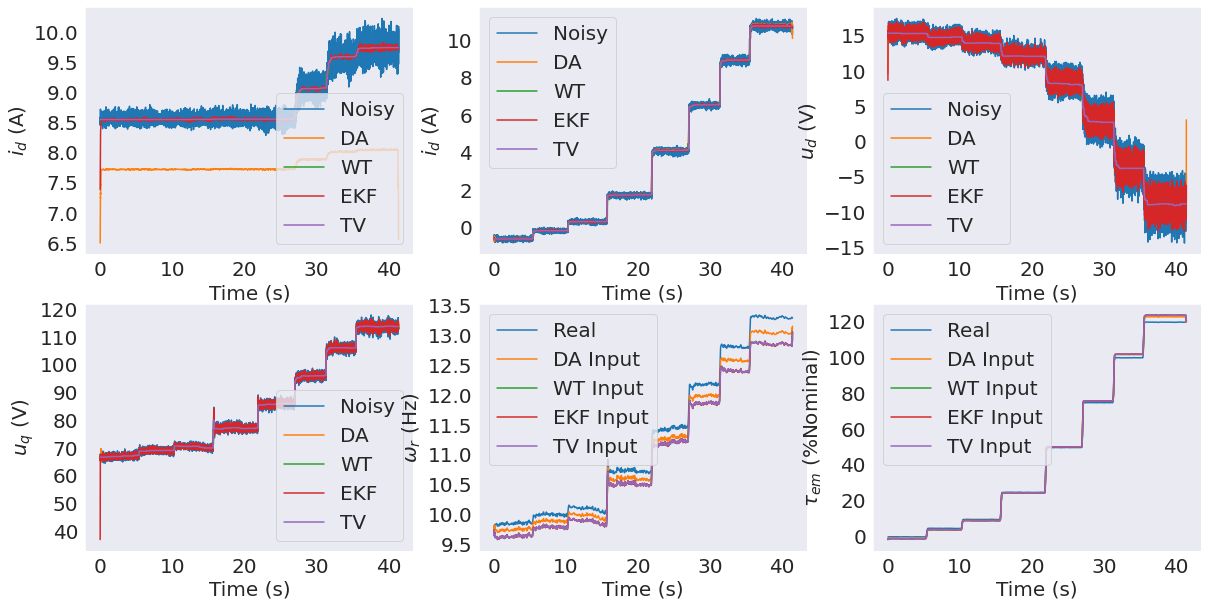

------- DA --------
Speed
SMAPE : 1.3916327607226728
R2 : 0.9803603958167421
RMSE : 0.16879162043433382
MAE : 0.1599887519014824
Torque
SMAPE : 21.228668871562498
R2 : 0.9990307153416957
RMSE : 1.3844598746114838
MAE : 1.0735140510336239
------- WT --------
Speed
SMAPE : 2.463266166429479
R2 : 0.9373185125657397
RMSE : 0.2940696841563557
MAE : 0.2804193212559003
Torque
SMAPE : 22.301692861420346
R2 : 0.9985240206786724
RMSE : 1.7192286578861773
MAE : 1.2478337857493254
------- EKF --------
Speed
SMAPE : 2.462703333322409
R2 : 0.9372949428647911
RMSE : 0.29409681207294147
MAE : 0.2803694411438902
Torque
SMAPE : 22.314446092290407
R2 : 0.9985218396529905
RMSE : 1.7205648384183774
MAE : 1.2484577293037957
------- TV --------
Speed
SMAPE : 2.463516457095965
R2 : 0.9373251142598675
RMSE : 0.2940625437649939
MAE : 0.2804431740866603
Torque
SMAPE : 22.28717657858986
R2 : 0.9985277079864172
RMSE : 1.717027034762164
MAE : 1.2472885169452084
OFVC4kW_LM20Hz_TorqueSteps_20190419_Data.mat


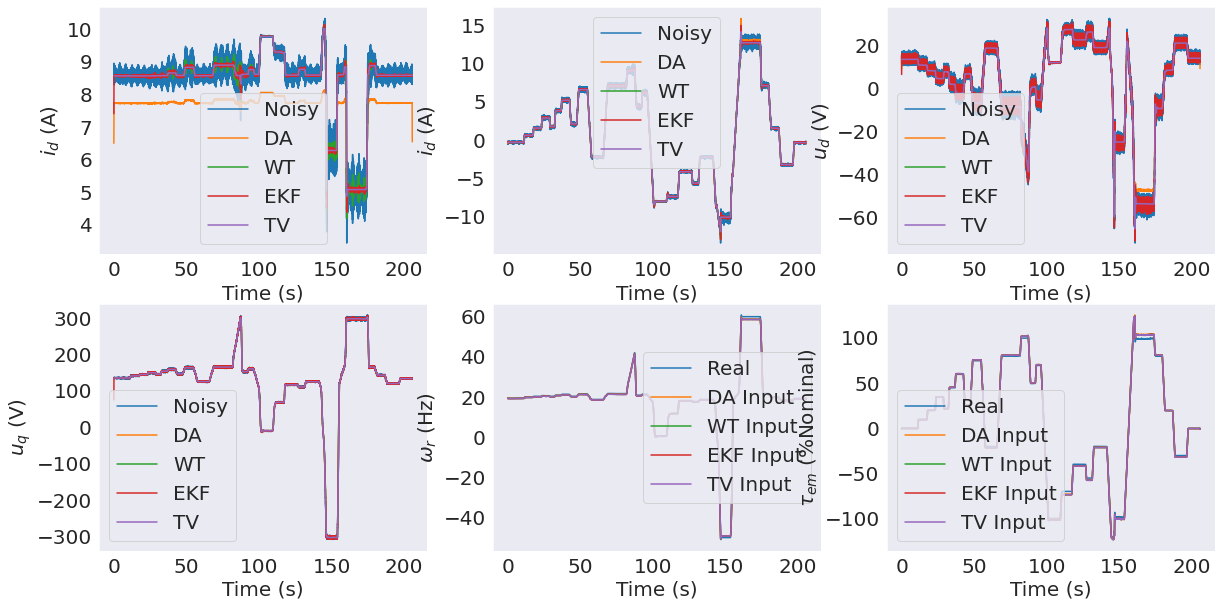

------- DA --------
Speed
SMAPE : 1.039928872278212
R2 : 0.9994830574828159
RMSE : 0.41783734336514344
MAE : 0.2755687884039124
Torque
SMAPE : 13.908304473400971
R2 : 0.9992227000888364
RMSE : 1.7267347821160894
MAE : 1.2481616496363992
------- WT --------
Speed
SMAPE : 2.619763101729471
R2 : 0.999283544017735
RMSE : 0.4912836465305271
MAE : 0.3811892698243479
Torque
SMAPE : 14.032184358192934
R2 : 0.9991585548282196
RMSE : 1.8006283811883097
MAE : 1.3633736849145752
------- EKF --------
Speed
SMAPE : 2.624873091530054
R2 : 0.9992840505677542
RMSE : 0.4911100433853403
MAE : 0.38111459484051835
Torque
SMAPE : 14.041231005000379
R2 : 0.9991576891891297
RMSE : 1.801585097446199
MAE : 1.3639152616693284
------- TV --------
Speed
SMAPE : 2.5726842604909415
R2 : 0.9992823305698512
RMSE : 0.4916477101875452
MAE : 0.38154781501801155
Torque
SMAPE : 14.015594857568109
R2 : 0.9991641134721833
RMSE : 1.7945289415520167
MAE : 1.359750479095178
OFVC4kW_LM30Hz_paliers_0to120PercTnom_Data.mat


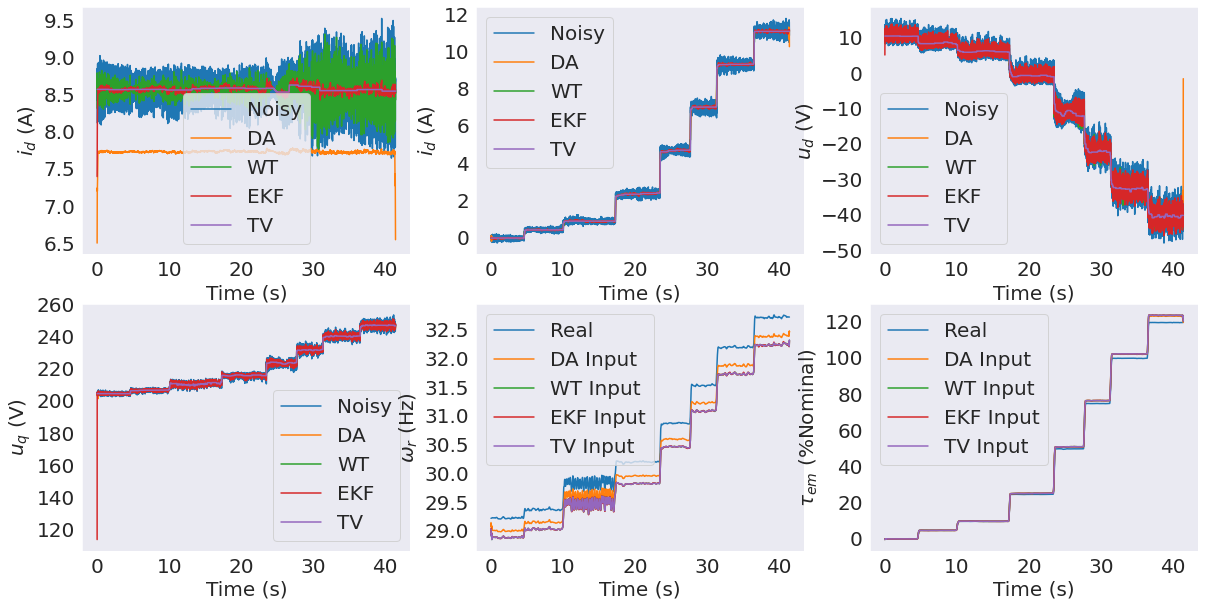

------- DA --------
Speed
SMAPE : 0.8619733550722772
R2 : 0.9503106265252927
RMSE : 0.2686119437155763
MAE : 0.26495192823414954
Torque
SMAPE : 5.949424404934013
R2 : 0.9986283477500116
RMSE : 1.6811925010601716
MAE : 1.1547261436342542
------- WT --------
Speed
SMAPE : 1.3097098530117999
R2 : 0.8848994069253476
RMSE : 0.4049558804470898
MAE : 0.40125817484975057
Torque
SMAPE : 6.227595129581986
R2 : 0.9983380908726303
RMSE : 1.8557173558809341
MAE : 1.2538721093448475
------- EKF --------
Speed
SMAPE : 1.3093334099569252
R2 : 0.8849515652082569
RMSE : 0.40487380820645996
MAE : 0.40114321342056214
Torque
SMAPE : 6.23980340316427
R2 : 0.9983368381490928
RMSE : 1.8564338802589753
MAE : 1.2541627096663497
------- TV --------
Speed
SMAPE : 1.3096978397102155
R2 : 0.8849201611537914
RMSE : 0.40493542480589995
MAE : 0.401252855150701
Torque
SMAPE : 5.95505501127684
R2 : 0.9983400615057478
RMSE : 1.8545427837292974
MAE : 1.252490457095402
OFVC4kW_LM45Hz_TorqueSteps_20190419_Data.mat


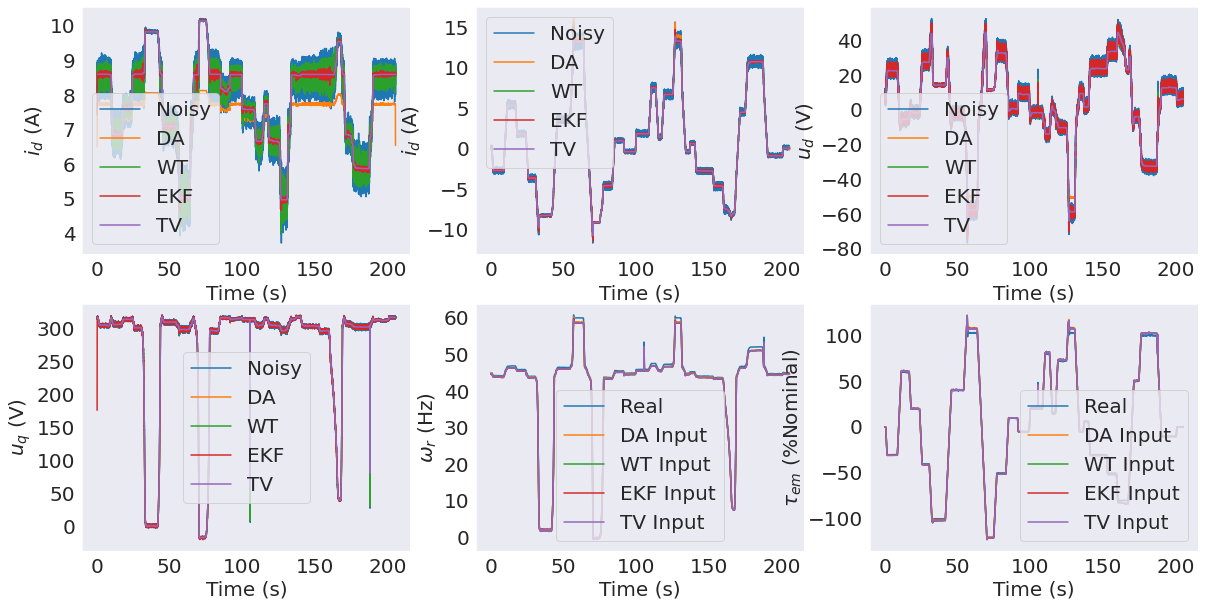

------- DA --------
Speed
SMAPE : 2.224874138666621
R2 : 0.9987315966794896
RMSE : 0.4860514237530666
MAE : 0.377798061277384
Torque
SMAPE : 3.6093652682755444
R2 : 0.9991590060769002
RMSE : 1.7848347978327042
MAE : 1.1636054097482753
------- WT --------
Speed
SMAPE : 3.0326903847826108
R2 : 0.9983124612504833
RMSE : 0.561204789381797
MAE : 0.4866691346542064
Torque
SMAPE : 3.674331256192728
R2 : 0.9991850776237959
RMSE : 1.7605730466671403
MAE : 1.2722410596803415
------- EKF --------
Speed
SMAPE : 3.03463546056479
R2 : 0.9983125842295818
RMSE : 0.5611861711878516
MAE : 0.4866405411444368
Torque
SMAPE : 3.720527939890104
R2 : 0.9991838394031738
RMSE : 1.7619435879299603
MAE : 1.2732858978894877
------- TV --------
Speed
SMAPE : 3.0212456398173972
R2 : 0.998301148573564
RMSE : 0.5630340920071423
MAE : 0.487515532673506
Torque
SMAPE : 3.3663573128793334
R2 : 0.9991898994513733
RMSE : 1.7551989606500868
MAE : 1.2663259576559172
OFVC4kW_LM50Hz_paliers_0to120PercTnom_Data.mat


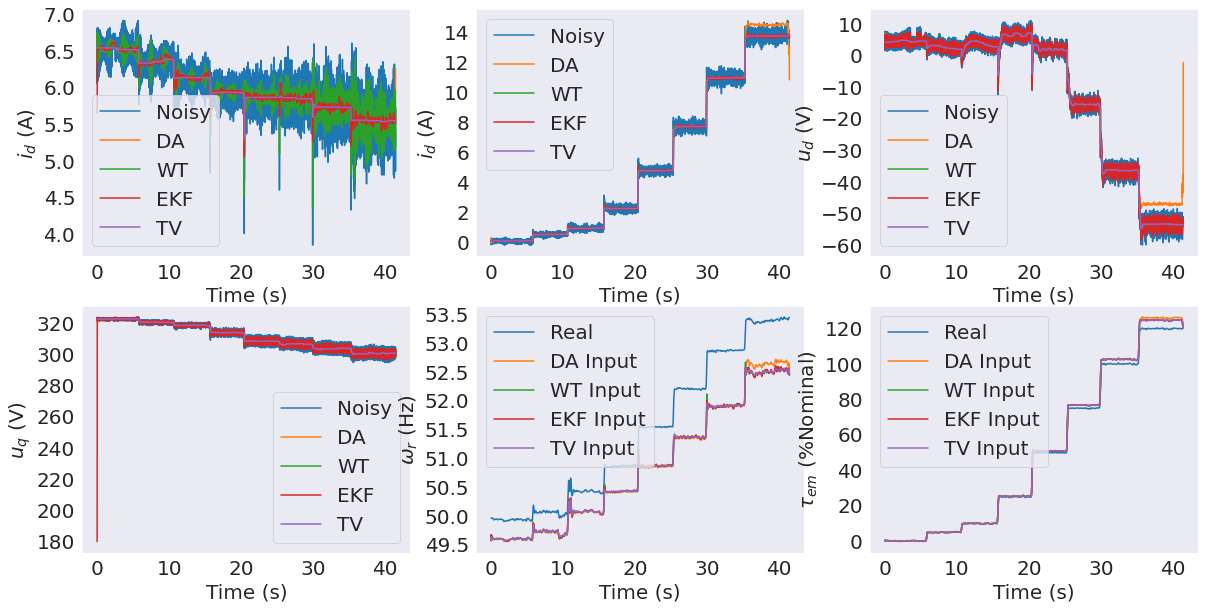

------- DA --------
Speed
SMAPE : 1.1439250150024254
R2 : 0.6408322744917879
RMSE : 0.6340050562166559
MAE : 0.5892248056826952
Torque
SMAPE : 16.089518879907263
R2 : 0.9968226513879568
RMSE : 2.6060958161800865
MAE : 1.6294490669826978
------- WT --------
Speed
SMAPE : 1.1656511778387182
R2 : 0.5941899611324741
RMSE : 0.6518396043047393
MAE : 0.600956413678115
Torque
SMAPE : 16.641440321665257
R2 : 0.9978016472766348
RMSE : 2.1524719232177576
MAE : 1.422925320837684
------- EKF --------
Speed
SMAPE : 1.1657158473335116
R2 : 0.5938030928848788
RMSE : 0.6519171819499994
MAE : 0.6009966866484188
Torque
SMAPE : 16.384141558540975
R2 : 0.9978007079703916
RMSE : 2.1529289766428885
MAE : 1.4236258708195138
------- TV --------
Speed
SMAPE : 1.1664474827653297
R2 : 0.5936718817218228
RMSE : 0.6518729215783502
MAE : 0.6013729375651204
Torque
SMAPE : 17.02365571669672
R2 : 0.9978034908961143
RMSE : 2.1515331269500693
MAE : 1.4237256428501734
OFVC4kW_LM60Hz_TorqueSteps_20190419_Data.mat


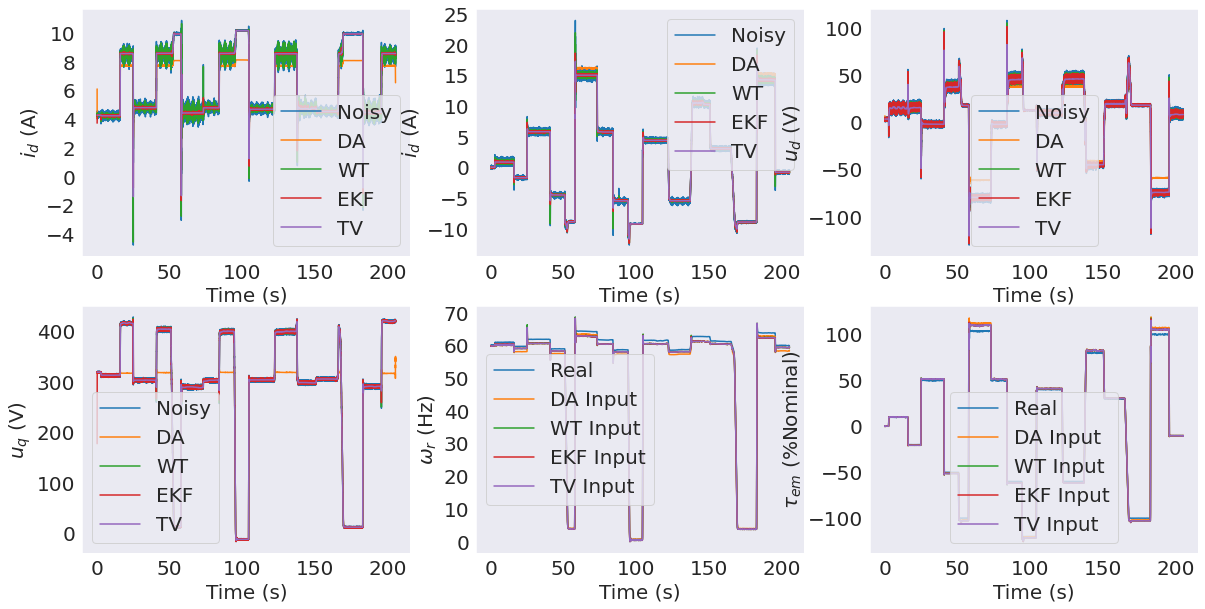

------- DA --------
Speed
SMAPE : 1.9869810599525417
R2 : 0.9964390313048227
RMSE : 1.1279252638118646
MAE : 1.016991750159161
Torque
SMAPE : 3.8514034301892632
R2 : 0.9979780754292176
RMSE : 3.097682497486509
MAE : 1.9636471595840435
------- WT --------
Speed
SMAPE : 2.576960017321387
R2 : 0.9974065988606847
RMSE : 0.967884522033556
MAE : 0.8520927220486666
Torque
SMAPE : 4.040247910175415
R2 : 0.9985618890748849
RMSE : 2.608784594732638
MAE : 1.9548246568959287
------- EKF --------
Speed
SMAPE : 2.575431444537945
R2 : 0.9974383257391425
RMSE : 0.961875662936869
MAE : 0.8499723434205194
Torque
SMAPE : 4.019118525188455
R2 : 0.9985689814286058
RMSE : 2.6022682347260098
MAE : 1.9511479885505147
------- TV --------
Speed
SMAPE : 2.546425830520721
R2 : 0.9974242547210399
RMSE : 0.9644805419081475
MAE : 0.851935352287156
Torque
SMAPE : 3.7951082060864403
R2 : 0.9985717177514104
RMSE : 2.599551881764245
MAE : 1.9487296404341798
OFVC4kW_LM68Hz_paliers_0to120PercTnom_Data.mat


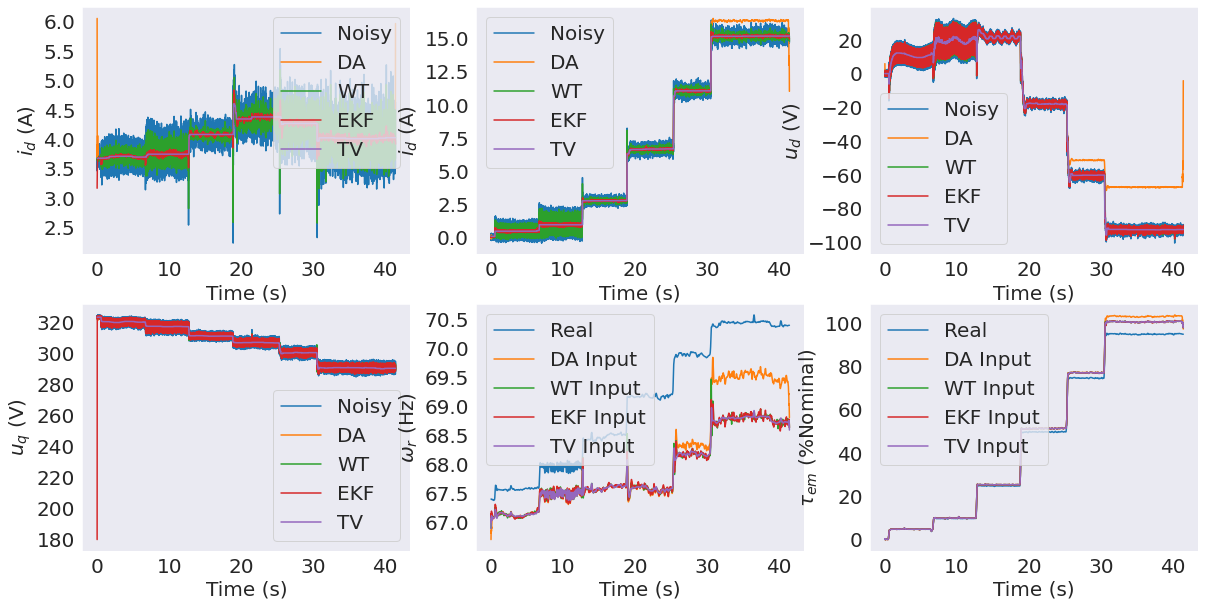

------- DA --------
Speed
SMAPE : 1.3617982343904482
R2 : -0.3831914642648502
RMSE : 1.0389950946932967
MAE : 0.9353779487416747
Torque
SMAPE : 4.765559662983315
R2 : 0.9886587970670108
RMSE : 4.090333979498944
MAE : 2.5608510176209163
------- WT --------
Speed
SMAPE : 1.6266286823905807
R2 : -3.3853398012418587
RMSE : 1.2501063179431045
MAE : 1.1183617294607544
Torque
SMAPE : 4.092364982627629
R2 : 0.9938602254802422
RMSE : 2.9431055777272377
MAE : 1.9718072237546937
------- EKF --------
Speed
SMAPE : 1.6269015842887746
R2 : -3.3995226227920794
RMSE : 1.2502773273608454
MAE : 1.1185544957265727
Torque
SMAPE : 4.111429783823454
R2 : 0.9938610076301775
RMSE : 2.9429193681105836
MAE : 1.970691555334468
------- TV --------
Speed
SMAPE : 1.6300366082636886
R2 : -3.416444042258986
RMSE : 1.2503681020790525
MAE : 1.1206905686262152
Torque
SMAPE : 3.4628564030986015
R2 : 0.9938639275764466
RMSE : 2.9422179925346565
MAE : 1.970970135076814
OFVC4kW_NoLM_SpeedVariations2_20190419_Data.mat


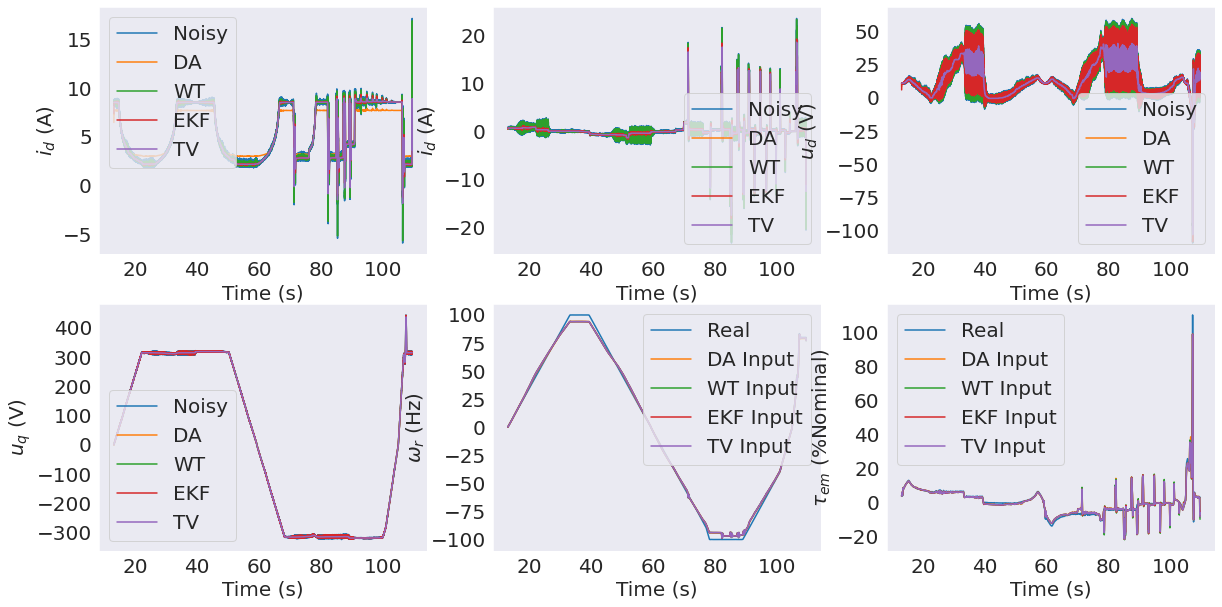

------- DA --------
Speed
SMAPE : 3.7636878514648653
R2 : 0.99801388060322
RMSE : 2.9888570115756514
MAE : 2.27533681223663
Torque
SMAPE : 53.71526780929224
R2 : 0.8321415724013053
RMSE : 3.2670199689003936
MAE : 1.3406068478538158
------- WT --------
Speed
SMAPE : 4.307774383980704
R2 : 0.9977896271867
RMSE : 3.1542466010426025
MAE : 2.4553546591230004
Torque
SMAPE : 50.755718645250674
R2 : 0.8237239756179029
RMSE : 3.3499356772584807
MAE : 1.3372473033930719
------- EKF --------
Speed
SMAPE : 4.303722322103131
R2 : 0.9978002108477817
RMSE : 3.1465067701748857
MAE : 2.452311721431731
Torque
SMAPE : 50.705613422043506
R2 : 0.8340498616588284
RMSE : 3.2274189195461727
MAE : 1.3096609501227918
------- TV --------
Speed
SMAPE : 4.302634856035334
R2 : 0.9977991220182447
RMSE : 3.1473361805868914
MAE : 2.451001042226546
Torque
SMAPE : 48.33968828969238
R2 : 0.8327941611223162
RMSE : 3.243416546590756
MAE : 1.295511258953798
OFVC4kW_NoLM_SpeedVariations_20190419_Data.mat


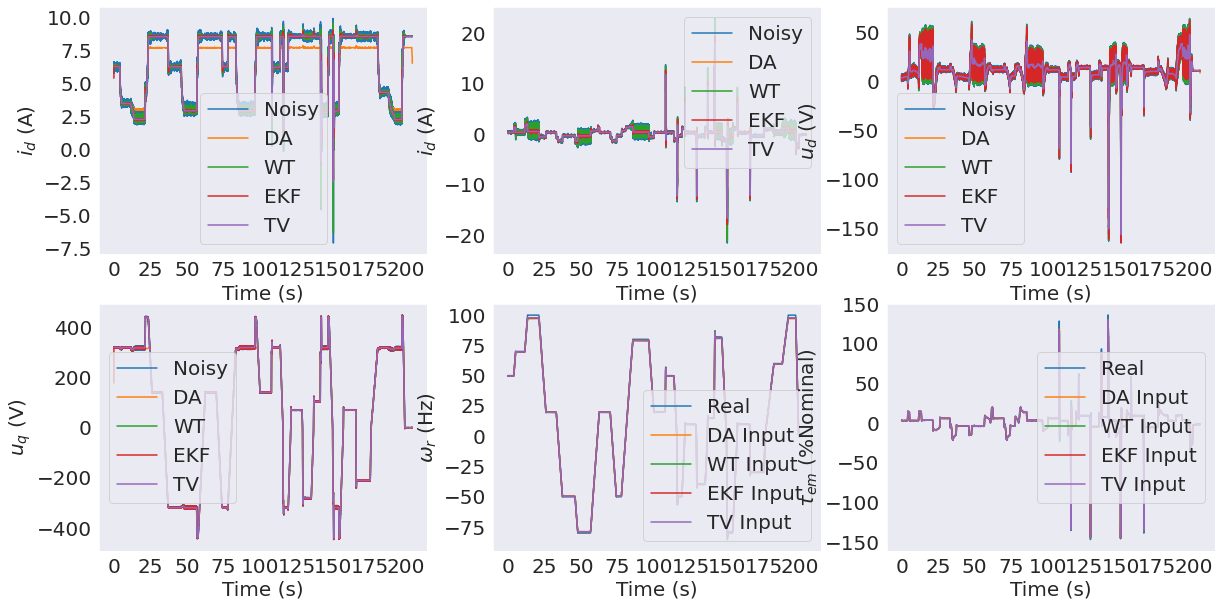

------- DA --------
Speed
SMAPE : 2.0427287693717875
R2 : 0.9995631078032468
RMSE : 1.109627930909819
MAE : 0.7326126319089759
Torque
SMAPE : 5.433028178304042
R2 : 0.9935965744724679
RMSE : 1.1371187952639497
MAE : 0.3798449912652793
------- WT --------
Speed
SMAPE : 2.2165793551052184
R2 : 0.9997395880488279
RMSE : 0.8598363833720347
MAE : 0.6310946524975637
Torque
SMAPE : 5.326290452904622
R2 : 0.9927177274220137
RMSE : 1.2121757512347093
MAE : 0.4008789415118162
------- EKF --------
Speed
SMAPE : 2.213173220375676
R2 : 0.9997429730685795
RMSE : 0.8542070032249899
MAE : 0.6288064566708019
Torque
SMAPE : 5.32434815611806
R2 : 0.9933940737927107
RMSE : 1.1523598240568802
MAE : 0.39329750096633914
------- TV --------
Speed
SMAPE : 2.2049802629960156
R2 : 0.9997411071280561
RMSE : 0.8572704063001025
MAE : 0.630539931494
Torque
SMAPE : 5.232920644147366
R2 : 0.9934317933529161
RMSE : 1.1463649893292178
MAE : 0.3859908889160923
OFVC4kW_NoLM_paliers_0to100Hz_Data.mat


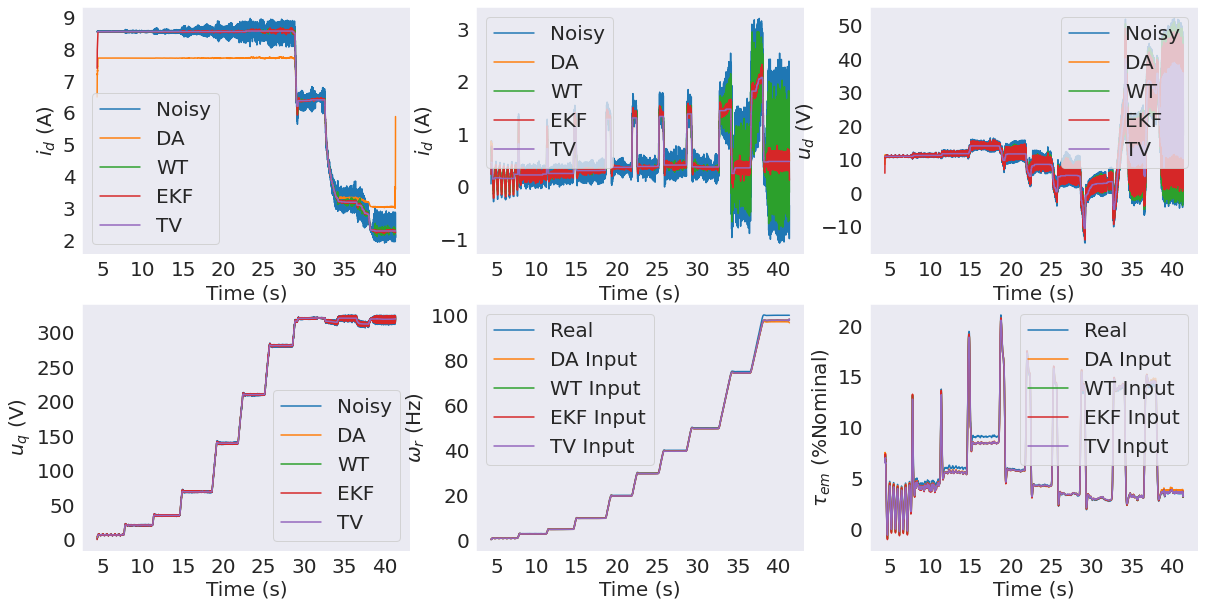

------- DA --------
Speed
SMAPE : 1.5870611340802891
R2 : 0.9989662002812822
RMSE : 1.0477198501050324
MAE : 0.5651173998875082
Torque
SMAPE : 5.7899663907597985
R2 : 0.9952713079679177
RMSE : 0.2912940142103401
MAE : 0.226485938324837
------- WT --------
Speed
SMAPE : 2.3267760044741634
R2 : 0.9993314154500869
RMSE : 0.8473422043492727
MAE : 0.5341291863051203
Torque
SMAPE : 5.791429634808203
R2 : 0.9952933302776296
RMSE : 0.29065654455227136
MAE : 0.2156982089544253
------- EKF --------
Speed
SMAPE : 2.3261347324149253
R2 : 0.9993322993109309
RMSE : 0.8467904859928839
MAE : 0.5340313351781085
Torque
SMAPE : 6.022763679244283
R2 : 0.9952352813694133
RMSE : 0.29301294366092046
MAE : 0.2169286000406869
------- TV --------
Speed
SMAPE : 2.3253120990711165
R2 : 0.9993314554547531
RMSE : 0.8473131895427012
MAE : 0.5343207861434845
Torque
SMAPE : 4.2901137701164975
R2 : 0.9952188522139082
RMSE : 0.29088508040578237
MAE : 0.21353679831983063


In [35]:
mat_files = glob.glob('../../../datasets/Data_27012021_noisy/real/*.mat')
mat_files.sort()

alpha = 0.1

spd_ekf_mae = []
spd_wt_mae = []
spd_tv_mae = []
spd_da_mae = []

trq_ekf_mae = []
trq_wt_mae = []
trq_tv_mae = []
trq_da_mae = []

spd_ekf_smape = []
spd_wt_smape = []
spd_tv_smape = []
spd_da_smape = []

trq_ekf_smape = []
trq_wt_smape = []
trq_tv_smape = []
trq_da_smape = []

for mat_file in mat_files:
    print (mat_file.split('/')[-1])
    
    data = loadmat(mat_file)

    st = 0
    w = -1

    x_id = np.stack([data['noisy_current_d'][0] / 30]) 
    x_iq = np.stack([data['noisy_current_q'][0] / 30])
    x_ud = np.stack([data['noisy_voltage_d'][0] / 300]) 
    x_uq = np.stack([data['noisy_voltage_q'][0] / 300])
    


    inp_id = torch.tensor([x_id[:, st:st+w]]).cuda().float()
    out_id = model_id(inp_id)
    out_id_da = out_id.data.cpu().numpy()[0]
    out_id_wt = wt(data['noisy_current_d'][0], 0.17)
    out_id_ekf = ekf(data['noisy_current_d'][0], 0.17)
    out_id_tv = tv(data['noisy_current_d'][0], 0.17)

    inp_iq = torch.tensor([x_iq[:, st:st+w]]).cuda().float()
    out_iq = model_iq(inp_iq)
    out_iq_da = out_iq.data.cpu().numpy()[0]
    out_iq_wt = wt(data['noisy_current_q'][0], 0.29)
    out_iq_ekf = ekf(data['noisy_current_q'][0], 0.29)
    out_iq_tv = tv(data['noisy_current_q'][0], 0.29)

    inp_ud = torch.tensor([x_ud[:, st:st+w]]).cuda().float()
    out_ud = model_ud(inp_ud)
    out_ud_da = out_ud.data.cpu().numpy()[0]
    out_ud_wt = wt(data['noisy_voltage_d'][0], 1.85)
    out_ud_ekf = ekf(data['noisy_voltage_d'][0], 1.85)
    out_ud_tv = tv(data['noisy_voltage_d'][0], 1.85)

    inp_uq = torch.tensor([x_uq[:, st:st+w]]).cuda().float()
    out_uq = model_uq(inp_uq)
    out_uq_da = out_uq.data.cpu().numpy()[0]
    out_uq_wt = wt(data['noisy_voltage_q'][0], 1.78)
    out_uq_ekf = ekf(data['noisy_voltage_q'][0], 1.78)
    out_uq_tv = tv(data['noisy_voltage_q'][0], 1.78)
    
    inp = torch.tensor([x[:, st:st+w]]).cuda().float()
    out_spd = model_spd(inp)
    out_spd = out_spd.data.cpu().numpy()[0]
    
    out_trq = model_trq(inp)
    out_trq = out_trq.data.cpu().numpy()[0]

    inps_da = torch.from_numpy(np.stack([[out_id_da[0], 
                                           out_iq_da[0], 
                                           out_ud_da[0], 
                                           out_uq_da[0]]])).cuda()
    inps_wt = torch.from_numpy(np.stack([[out_id_wt / 30, 
                                           out_iq_wt / 30, 
                                           out_ud_wt / 300, 
                                           out_uq_wt / 300]])).cuda().float()
    inps_ekf = torch.from_numpy(np.stack([[out_id_ekf / 30, 
                                           out_iq_ekf / 30, 
                                           out_ud_ekf / 300, 
                                           out_uq_ekf / 300]])).cuda().float()
    inps_tv = torch.from_numpy(np.stack([[out_id_tv / 30, 
                                           out_iq_tv / 30, 
                                           out_ud_tv / 300, 
                                           out_uq_tv / 300]])).cuda().float()
    
    out_spd_da = model_spd(inps_da)
    out_spd_da = out_spd_da.data.cpu().numpy()[0]
    out_spd_wt = model_spd(inps_wt)
    out_spd_wt = out_spd_wt.data.cpu().numpy()[0]
    out_spd_ekf = model_spd(inps_ekf)
    out_spd_ekf = out_spd_ekf.data.cpu().numpy()[0]
    out_spd_tv = model_spd(inps_tv)
    out_spd_tv = out_spd_tv.data.cpu().numpy()[0]
    
    out_trq_da = model_trq(inps_da)
    out_trq_da = out_trq_da.data.cpu().numpy()[0]
    out_trq_wt = model_trq(inps_wt)
    out_trq_wt = out_trq_wt.data.cpu().numpy()[0]
    out_trq_ekf = model_trq(inps_ekf)
    out_trq_ekf = out_trq_ekf.data.cpu().numpy()[0]
    out_trq_tv = model_trq(inps_tv)
    out_trq_tv = out_trq_tv.data.cpu().numpy()[0]
    
    
    speed_pred_da = np.copy(data['speed'][0])
    speed_pred_da[:-1] = out_spd_da[0] * 80
    speed_pred_da = alpha * speed_pred_da + (1 - alpha) * data['speed'][0]

    torque_pred_da = np.copy(data['torque'][0])
    torque_pred_da[:-1] = out_trq_da[0] * 120
    torque_pred_da = alpha * torque_pred_da + (1 - alpha) * data['torque'][0]
    
    speed_pred_wt = out_spd_wt[0] * 80
    speed_pred_wt = alpha * speed_pred_wt + (1 - alpha) * data['speed'][0]

    torque_pred_wt = out_trq_wt[0] * 120
    torque_pred_wt = alpha * torque_pred_wt + (1 - alpha) * data['torque'][0]
    
    speed_pred_ekf = out_spd_ekf[0] * 80
    speed_pred_ekf = alpha * speed_pred_ekf + (1 - alpha) * data['speed'][0]

    torque_pred_ekf = out_trq_ekf[0] * 120
    torque_pred_ekf = alpha * torque_pred_ekf + (1 - alpha) * data['torque'][0]
    
    speed_pred_tv = out_spd_tv[0] * 80
    speed_pred_tv = alpha * speed_pred_tv + (1 - alpha) * data['speed'][0]

    torque_pred_tv = out_trq_tv[0] * 120
    torque_pred_tv = alpha * torque_pred_tv + (1 - alpha) * data['torque'][0]
    
    
    sns.set_style("dark")
    fig = plt.figure(figsize=(20,10))

    plt.subplot(2, 3, 1)
    plt.plot(data['time'][0, st:st+w], data['noisy_current_d'][0, st:st+w], label='Noisy')
    plt.plot(data['time'][0, st:st+w], out_id_da[0] * 30, label='DA')
    plt.plot(data['time'][0, st:st+w], out_id_wt[st:st+w], label='WT')
    plt.plot(data['time'][0, st:st+w], out_id_ekf[st:st+w], label='EKF')
    plt.plot(data['time'][0, st:st+w], out_id_tv[st:st+w], label='TV')
#     plt.plot(data['time'][0, st:st+w], data['current_d'][0, st:st+w], label='Real')
    plt.ylabel(r'$i_d$ (A)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)

    plt.subplot(2, 3, 2)
    plt.plot(data['time'][0, st:st+w], data['noisy_current_q'][0, st:st+w], label='Noisy')
    plt.plot(data['time'][0, st:st+w], out_iq_da[0] * 30, label='DA')
    plt.plot(data['time'][0, st:st+w], out_iq_wt[st:st+w], label='WT')
    plt.plot(data['time'][0, st:st+w], out_iq_ekf[st:st+w], label='EKF')
    plt.plot(data['time'][0, st:st+w], out_iq_tv[st:st+w], label='TV')
#     plt.plot(data['time'][0, st:st+w], data['current_q'][0, st:st+w], label='Real')
    plt.ylabel(r'$i_d$ (A)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)

    plt.subplot(2, 3, 3)
    plt.plot(data['time'][0, st:st+w], data['noisy_voltage_d'][0, st:st+w], label='Noisy')
    plt.plot(data['time'][0, st:st+w], out_ud_da[0] * 300, label='DA')
    plt.plot(data['time'][0, st:st+w], out_ud_wt[st:st+w], label='WT')
    plt.plot(data['time'][0, st:st+w], out_ud_ekf[st:st+w], label='EKF')
    plt.plot(data['time'][0, st:st+w], out_ud_tv[st:st+w], label='TV')
#     plt.plot(data['time'][0, st:st+w], data['voltage_d'][0, st:st+w], label='Real')
    plt.ylabel(r'$u_d$ (V)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)

    plt.subplot(2, 3, 4)
    plt.plot(data['time'][0, st:st+w], data['noisy_voltage_q'][0, st:st+w], label='Noisy')
    plt.plot(data['time'][0, st:st+w], out_uq_da[0] * 300, label='DA')
    plt.plot(data['time'][0, st:st+w], out_uq_wt[st:st+w], label='WT')
    plt.plot(data['time'][0, st:st+w], out_uq_ekf[st:st+w], label='EKF')
    plt.plot(data['time'][0, st:st+w], out_uq_tv[st:st+w], label='TV')
#     plt.plot(data['time'][0, st:st+w], data['voltage_q'][0, st:st+w], label='Real')
    plt.ylabel(r'$u_q$ (V)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    
    plt.subplot(2, 3, 5)
    plt.plot(data['time'][0, st:st+w], data['speed'][0, st:st+w], label='Real')
    plt.plot(data['time'][0, st:st+w], speed_pred_da[st:st+w], label='DA Input')
    plt.plot(data['time'][0, st:st+w], speed_pred_wt[st:st+w], label='WT Input')
    plt.plot(data['time'][0, st:st+w], speed_pred_ekf[st:st+w], label='EKF Input')
    plt.plot(data['time'][0, st:st+w], speed_pred_tv[st:st+w], label='TV Input')
    plt.ylabel(r'$\omega_r$ (Hz)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    
    plt.subplot(2, 3, 6)
    plt.plot(data['time'][0, st:st+w], data['torque'][0, st:st+w], label='Real')
    plt.plot(data['time'][0, st:st+w], torque_pred_da[st:st+w], label='DA Input')
    plt.plot(data['time'][0, st:st+w], torque_pred_wt[st:st+w], label='WT Input')
    plt.plot(data['time'][0, st:st+w], torque_pred_ekf[st:st+w], label='EKF Input')
    plt.plot(data['time'][0, st:st+w], torque_pred_tv[st:st+w], label='TV Input')
    plt.ylabel(r'$\tau_{em}$ (%Nominal)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    
    plt.show()
    
    
    print ('------- DA --------')
    compute_ml(data, speed_pred_da, torque_pred_da)
    
    print ('------- WT --------')
    compute_ml(data, speed_pred_wt, torque_pred_wt)
    
    print ('------- EKF --------')
    compute_ml(data, speed_pred_ekf, torque_pred_ekf)
    
    print ('------- TV --------')
    compute_ml(data, speed_pred_tv, torque_pred_tv)
    
    spd_ekf_mae.append(mae(speed_pred_ekf[250:-250], data['speed'][0, 250: -250]))
    spd_wt_mae.append(mae(speed_pred_wt[250:-250], data['speed'][0, 250: -250]))
    spd_tv_mae.append(mae(speed_pred_tv[250:-250], data['speed'][0, 250: -250]))
    spd_da_mae.append(mae(speed_pred_da[250:-250], data['speed'][0, 250: -250]))

    trq_ekf_mae.append(mae(torque_pred_ekf[250:-250], data['torque'][0, 250: -250]))
    trq_wt_mae.append(mae(torque_pred_wt[250:-250], data['torque'][0, 250: -250]))
    trq_tv_mae.append(mae(torque_pred_tv[250:-250], data['torque'][0, 250: -250]))
    trq_da_mae.append(mae(torque_pred_da[250:-250], data['torque'][0, 250: -250]))

    spd_ekf_smape.append(smape(speed_pred_ekf[250:-250], data['speed'][0, 250: -250]))
    spd_wt_smape.append(smape(speed_pred_wt[250:-250], data['speed'][0, 250: -250]))
    spd_tv_smape.append(smape(speed_pred_tv[250:-250], data['speed'][0, 250: -250]))
    spd_da_smape.append(smape(speed_pred_da[250:-250], data['speed'][0, 250: -250]))

    trq_ekf_smape.append(smape(torque_pred_ekf[250:-250], data['torque'][0, 250: -250]))
    trq_wt_smape.append(smape(torque_pred_wt[250:-250], data['torque'][0, 250: -250]))
    trq_tv_smape.append(smape(torque_pred_tv[250:-250], data['torque'][0, 250: -250]))
    trq_da_smape.append(smape(torque_pred_da[250:-250], data['torque'][0, 250: -250]))

In [40]:

# print (np.mean(spd_ekf_mae))
# print (np.mean(spd_wt_mae))
# print (np.mean(spd_tv_mae))
# print (np.mean(spd_da_mae))

# print (np.mean(trq_ekf_mae))
# print (np.mean(trq_wt_mae)) 
# print (np.mean(trq_tv_mae)) 
# print (np.mean(trq_da_mae)) 

# print (np.mean(spd_ekf_smape) * 9)
# print (np.mean(spd_wt_smape)  * 9)
# print (np.mean(spd_tv_smape)  * 9)
# print (np.mean(spd_da_smape)  * 9)

# print (np.mean(trq_ekf_smape) * 3.4)
# print (np.mean(trq_wt_smape) * 3.4)
# print (np.mean(trq_tv_smape) * 3.4)
# print (np.mean(trq_da_smape) * 3.4)

0.776005585142245
0.7768023409590769
0.7767349939849721
0.7199653570974636
1.2229292743303204
1.2264172656788976
1.218921007602023
1.2539457969694743
20.526893654792012
20.52584943284616
20.437251032595288
14.991158002246666
41.375912000091716
41.408434409809715
40.146232424234846
41.93789619430417
